## Expert Knowledge Worker

### A question answering agent that is an expert knowledge worker
### To be used by employees of Insurellm, an Insurance Tech company
### The agent needs to be accurate and the solution should be low cost.

This project will use RAG (Retrieval Augmented Generation) to ensure our question/answering assistant has high accuracy.


In [1]:
# imports

import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [2]:
# imports for langchain, plotly and Chroma

from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_chroma import Chroma
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain.embeddings import HuggingFaceEmbeddings

In [3]:
# price is a factor for our company, so we're going to use a low cost model

MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [8]:
# Load environment variables in a file called .env

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [6]:
folders = glob.glob("knowledge-base/*")

def add_metadata(doc, doc_type):
    doc.metadata["doc_type"] = doc_type
    return doc

text_loader_kwargs = {'encoding': 'utf-8'}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    documents.extend([add_metadata(doc, doc_type) for doc in folder_docs])

text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

print(f"Total number of chunks: {len(chunks)}")
print(f"Document types found: {set(doc.metadata['doc_type'] for doc in documents)}")

Created a chunk of size 1088, which is longer than the specified 1000


Total number of chunks: 123
Document types found: {'contracts', 'employees', 'products', 'company'}


In [9]:
embeddings = OpenAIEmbeddings()

if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

# Create vectorstore

vectorstore = Chroma.from_documents(documents=chunks, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} documents")

Vectorstore created with 123 documents


In [10]:
collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")

There are 123 vectors with 1,536 dimensions in the vector store


## Visualizing the Vector Store


In [11]:
result = collection.get(include=['embeddings', 'documents', 'metadatas'])
vectors = np.array(result['embeddings'])
documents = result['documents']
metadatas = result['metadatas']
doc_types = [metadata['doc_type'] for metadata in metadatas]
colors = [['blue', 'green', 'red', 'orange'][['products', 'employees', 'contracts', 'company'].index(t)] for t in doc_types]

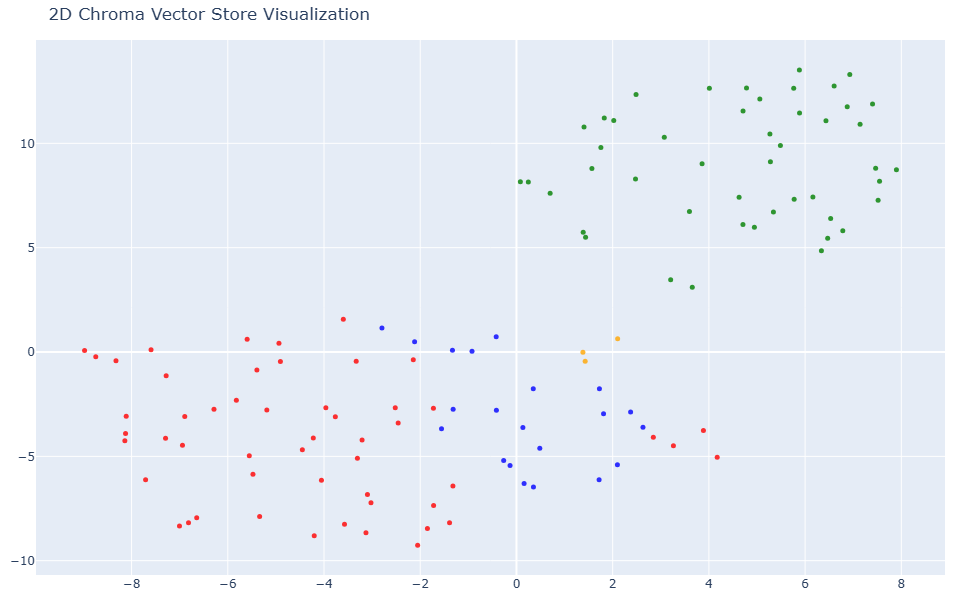

In [13]:
# 2D Visualize

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

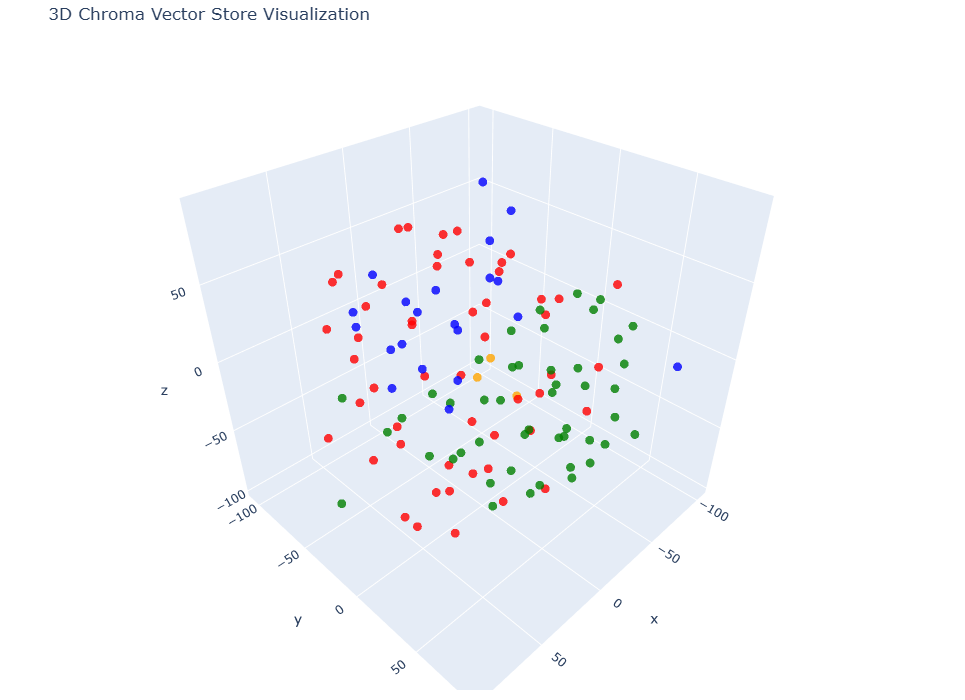

In [14]:
# 3D Visualize

tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D Chroma Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## Use LangChain to bring it all together

In [16]:
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

retriever = vectorstore.as_retriever()

conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

C:\Users\acer\AppData\Local\Temp\ipykernel_19624\1674703661.py:3: LangChainDeprecationWarning:

Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/



## Use Gradio for a Chat interface

In [18]:
def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

In [19]:
view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [21]:
# See what gets sent behind the scenes for the error

from langchain_core.callbacks import StdOutCallbackHandler

llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

retriever = vectorstore.as_retriever()

conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory, callbacks=[StdOutCallbackHandler()])

query = "Who received the prestigious IIOTY award in 2023?"
result = conversation_chain.invoke({"question": query})
answer = result["answer"]
print("\nAnswer:", answer)



> Entering new ConversationalRetrievalChain chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
System: Use the following pieces of context to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
----------------
- **2022**: **Satisfactory**  
  Avery focused on rebuilding team dynamics and addressing employee concerns, leading to overall improvement despite a saturated market.  

- **2023**: **Exceeds Expectations**  
  Market leadership was regained with innovative approaches to personalized insurance solutions. Avery is now recognized in industry publications as a leading voice in Insurance Tech innovation.

## Annual Performance History
- **2020:**  
  - Completed onboarding successfully.  
  - Met expectations in delivering project milestones.  
  - Received positive feedback from the team leads.

- **2021:**  
  - Achieved a 95% success rate in proje

In [22]:
# Create a new Chat with OpenAI, increase chunks given to the prompt
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

retriever = vectorstore.as_retriever(search_kwargs={"k": 25})

conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [23]:
def chat(question, history):
    result = conversation_chain.invoke({"question": question})
    return result["answer"]

In [24]:
view = gr.ChatInterface(chat, type="messages").launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
